## Setting Up and Importing Libraries
In this step, we'll import the necessary libraries and modules. We'll also ensure the correct path is set to access our custom modules.

In [1]:
# Import necessary libraries
import pandas as pd
import os
import sys
import json


In [2]:
# Make sure that the current working directory is the parent directory of the project
os.chdir(os.path.join(os.getcwd(), '..'))
print(os.getcwd())

/home/rita/TRUST_AI/trustframework/codice


In [3]:
from codice.cfsearch import CFsearch
from codice.dataset import Dataset
from codice.cemodels.base_model import BaseModel
from codice.cemodels.sklearn_model import SklearnModel
from codice.ceinstance.instance_sampler import CEInstanceSampler
from codice.config import Config
from codice.transformer import Transformer
from codice.ceinstance.instance_factory import InstanceFactory
from codice import load_datasets

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [5]:
# Loading dataset and trianing model
input=pd.read_csv('datasets/diabetes.csv',sep=',')

#get X and y
print(input.columns)
X=input.copy().drop(['Class variable'], axis=1)
y=input.copy()['Class variable']
#scaler = MinMaxScaler()
#X_normalized = scaler.fit_transform(X)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Optimized parameters
C_optimized = 0.23357214690901212
class_weight_optimized = 'balanced'
solver_optimized = 'liblinear'
model_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(max_iter=1000))
])
model_pipeline.fit(X_train, y_train)
# Check the accuracy of the model
print("Accuracy on training set: ", model_pipeline.score(X_train, y_train))
print("Accuracy on test set: ", model_pipeline.score(X_test, y_test))

Index(['Number of times pregnant',
       'Plasma glucose concentration a 2 hours in an oral glucose tolerance test',
       'Diastolic blood pressure (mm Hg)', 'Triceps skin fold thickness (mm)',
       '2-Hour serum insulin (mu U/ml)',
       'Body mass index (weight in kg/(height in m)^2)',
       'Diabetes pedigree function', 'Age (years)', 'Class variable'],
      dtype='object')
Accuracy on training set:  0.7756874095513748
Accuracy on test set:  0.7012987012987013


## Loading Configuration
Here, we'll load our configuration files which dictate various parameters for our counterfactual search. It includes dataset details, feature management, and other related configurations.

In [6]:
# Load configuration
config_file_path = "config/conf_diabetes.yaml"
config = Config(config_file_path)

with open("config/constraints_conf_diabetes.json", 'r') as file:
    constraints = json.load(file)

print("Configuration Loaded:")
print(config)

Configuration Loaded:


## Preparing Dataset and Model
In this section, we initialize our dataset, model, and the required transformers. We'll also define a sample instance for which we wish to find the counterfactuals.

In [7]:
# Set the target instance path
target_instance_json = "input_instance/instance_diabetes.json"

# Load the dataset and set up the necessary objects
#load_datasets.download("diabetes")

In [8]:
data = Dataset(config.get_config_value("dataset"), "Class variable")
normalization_transformer = Transformer(data, config)
instance_factory = InstanceFactory(data)
sampler = CEInstanceSampler(config, normalization_transformer, instance_factory)

model = BaseModel(config.get_config_value("model"), model_pipeline)

Features verified
Continious features: ['Number of times pregnant', 'Plasma glucose concentration a 2 hours in an oral glucose tolerance test', 'Diastolic blood pressure (mm Hg)', 'Triceps skin fold thickness (mm)', '2-Hour serum insulin (mu U/ml)', 'Body mass index (weight in kg/(height in m)^2)', 'Diabetes pedigree function', 'Age (years)']
Categorical features: []
Dataset preprocessed
Feature: Diastolic blood pressure (mm Hg)
Range: [0, 122]
Feature: Body mass index (weight in kg/(height in m)^2)
Range: [0.0, 67.1]
Feature: 2-Hour serum insulin (mu U/ml)
Range: [0, 846]
Feature: Age (years)
Range: [21, 81]
Feature: Diabetes pedigree function
Range: [0.078, 2.42]
Feature: Plasma glucose concentration a 2 hours in an oral glucose tolerance test
Range: [0, 199]
Feature: Triceps skin fold thickness (mm)
Range: [0, 99]
Feature: Number of times pregnant
Range: [0, 17]
Constraint Type: immutable


In [9]:
# Set the target instance path
target_instance_json = "input_instance/instance_diabetes.json"

## Finding Counterfactuals
With everything set up, we'll now search for counterfactuals for our sample instance using the CFsearch object.

In [10]:
# Create a CFsearch object
config_for_cfsearch = config.get_config_value("cfsearch")
search = CFsearch(normalization_transformer, model, sampler, config,
                  optimizer_name=config_for_cfsearch["optimizer"], 
                  distance_continuous=config_for_cfsearch["continuous_distance"], 
                  distance_categorical=config_for_cfsearch["categorical_distance"], 
                  loss_type=config_for_cfsearch["loss_type"], 
                  coherence=config_for_cfsearch["coherence"],
                  objective_function_weights=config_for_cfsearch["objective_function_weights"])

# Load target instance and find counterfactuals
with open(target_instance_json, 'r') as file:
    target_instance_json_content = file.read()

target_instance = instance_factory.create_instance_from_json(target_instance_json_content)

In [11]:
counterfactuals = search.find_counterfactuals(target_instance, number_cf=1, desired_class="opposite", maxiterations=50)

Valid counterfactuals were found:  {'Number of times pregnant': 0.0005100000000000007, 'Plasma glucose concentration a 2 hours in an oral glucose tolerance test': 55.750490739513566, 'Diastolic blood pressure (mm Hg)': 42.40302422184448, 'Triceps skin fold thickness (mm)': 35.523999339913495, '2-Hour serum insulin (mu U/ml)': 172.1942282604426, 'Body mass index (weight in kg/(height in m)^2)': 44.225406467702456, 'Diabetes pedigree function': 2.1877900544556494, 'Age (years)': 31.650375779578745}


## Evaluation and Visualization
Once the counterfactuals are generated, it's crucial to evaluate and visualize them. This helps in understanding how the counterfactuals differ from the original instance and assessing their quality.

In [12]:
# Evaluate and visualize the counterfactuals
search.evaluate_counterfactuals(target_instance, counterfactuals)

# Display the counterfactuals and original instance in the notebook
display_df = search.visualize_as_dataframe(target_instance, counterfactuals)
display(display_df)

Feature Number of times pregnant changed its value from 0 to 0.0005100000000000007
probability_sign: [-1.  1.], type: <class 'numpy.ndarray'>
required_label: [0], type: <class 'numpy.ndarray'>
Modified required_label: 0, type: <class 'int'>
Feature Plasma glucose concentration a 2 hours in an oral glucose tolerance test changed its value from 137 to 55.750490739513566
probability_sign: [ 1. -1.], type: <class 'numpy.ndarray'>
required_label: [0], type: <class 'numpy.ndarray'>
Modified required_label: 0, type: <class 'int'>
Feature Diastolic blood pressure (mm Hg) changed its value from 40 to 42.40302422184448
probability_sign: [ 1. -1.], type: <class 'numpy.ndarray'>
required_label: [0], type: <class 'numpy.ndarray'>
Modified required_label: 0, type: <class 'int'>
Feature Triceps skin fold thickness (mm) changed its value from 35 to 35.523999339913495
probability_sign: [-1.  1.], type: <class 'numpy.ndarray'>
required_label: [0], type: <class 'numpy.ndarray'>
Modified required_label: 0

,Number of times pregnant,Plasma glucose concentration a 2 hours in an oral glucose tolerance test,Diastolic blood pressure (mm Hg),Triceps skin fold thickness (mm),2-Hour serum insulin (mu U/ml),Body mass index (weight in kg/(height in m)^2),Diabetes pedigree function,Age (years)
0,0,137,40,35,168,43.1,2.288,33



Counterfactual set (new outcome: [array([0])])


,Number of times pregnant,Plasma glucose concentration a 2 hours in an oral glucose tolerance test,Diastolic blood pressure (mm Hg),Triceps skin fold thickness (mm),2-Hour serum insulin (mu U/ml),Body mass index (weight in kg/(height in m)^2),Diabetes pedigree function,Age (years)
0,0.0005100000000000007,55.750490739513566,42.40302422184448,35.523999339913495,172.1942282604426,44.225406467702456,2.1877900544556494,31.650375779578745


None

## Storing the Results
For reproducibility and further analysis, we'll store the counterfactuals and their evaluations in designated folders.

In [13]:
# Store results
search.store_counterfactuals(config.get_config_value("output_folder"), "diabetes_first_test")
search.store_evaluations(config.get_config_value("output_folder"), "diabetes_first_test")

Store counterfactuals to  results/diabetes_first_test_0.json
Store counterfactuals evaluation to  results/diabetes_first_test_eval_0.json


In [14]:
# "Class variable" is output variable

In [15]:
diab_1_data = data.data.loc[data.data["Class variable"]==1, :]
diab_0_data = data.data.loc[data.data["Class variable"]==0, :]

<Axes: >

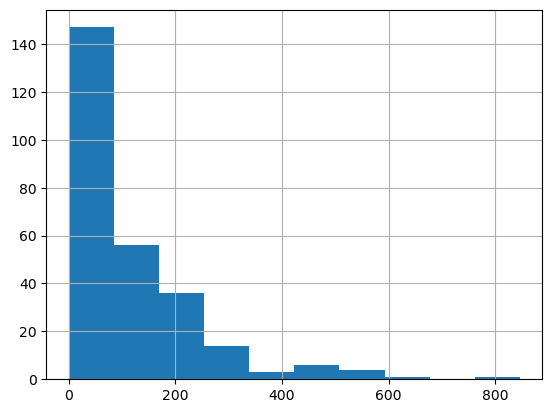

In [16]:
diab_1_data["2-Hour serum insulin (mu U/ml)"].hist()

<Axes: >

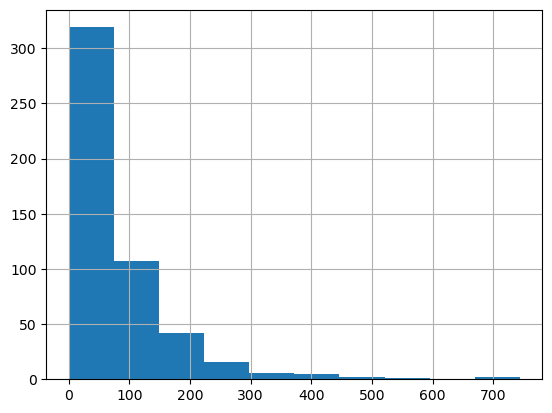

In [17]:
diab_0_data["2-Hour serum insulin (mu U/ml)"].hist()

<Axes: >

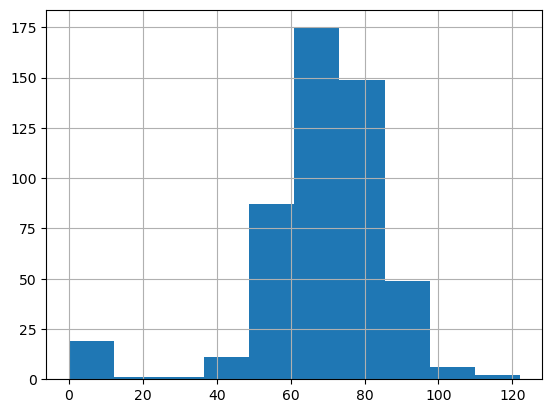

In [18]:
diab_0_data["Diastolic blood pressure (mm Hg)"].hist()

<Axes: >

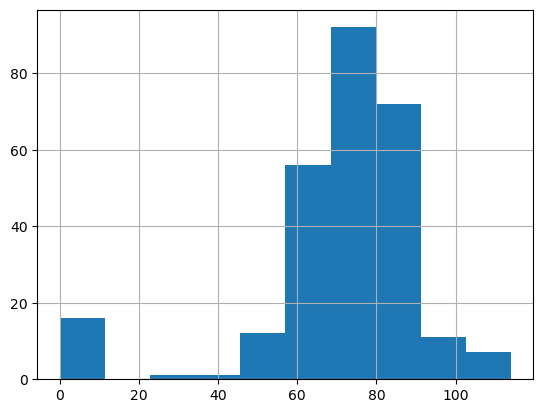

In [19]:
diab_1_data["Diastolic blood pressure (mm Hg)"].hist()

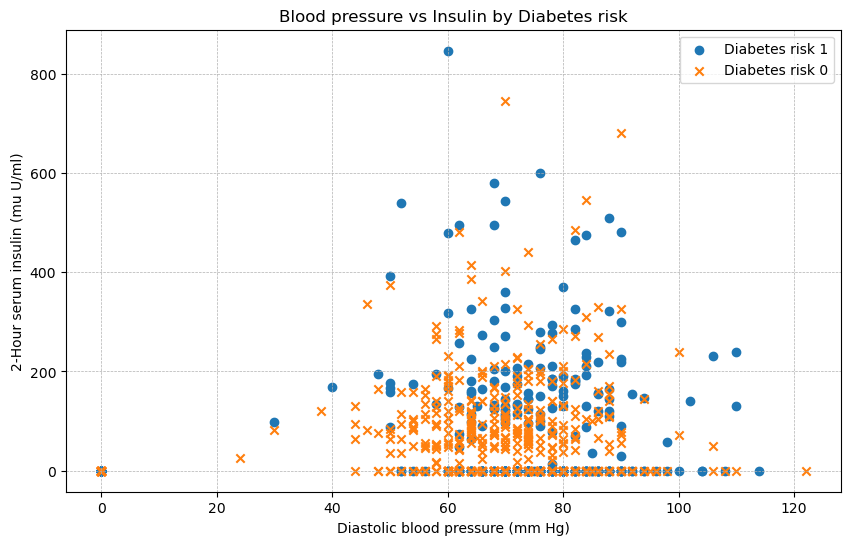

In [20]:
import matplotlib.pyplot as plt
import numpy as np
# Plot settings
plt.figure(figsize=(10, 6))

# Plot each class with different markers
plt.scatter(diab_1_data["Diastolic blood pressure (mm Hg)"], diab_1_data["2-Hour serum insulin (mu U/ml)"], marker='o', label='Diabetes risk 1')
plt.scatter(diab_0_data["Diastolic blood pressure (mm Hg)"], diab_0_data["2-Hour serum insulin (mu U/ml)"], marker='x', label='Diabetes risk 0')



# Adding grid, labels and legend
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlabel("Diastolic blood pressure (mm Hg)")
plt.ylabel("2-Hour serum insulin (mu U/ml)")
plt.title('Blood pressure vs Insulin by Diabetes risk')
plt.legend()

# Show plot
plt.show()

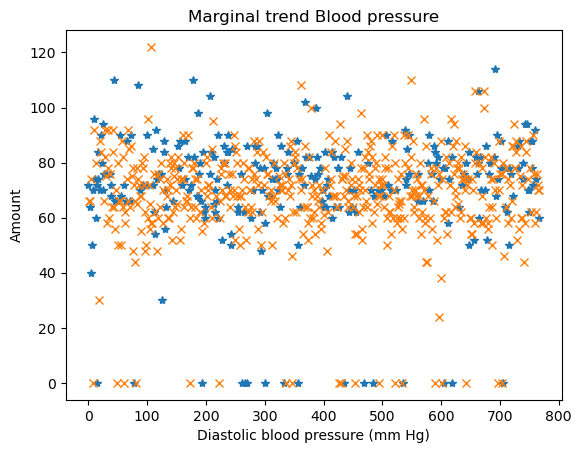

In [21]:
# Marginal influence of blood pressure
# Draw marginal trend
import matplotlib.pyplot as plt
import numpy as np
plt.plot(diab_1_data["Diastolic blood pressure (mm Hg)"], "*")
plt.plot(diab_0_data["Diastolic blood pressure (mm Hg)"], "x")
plt.xlabel("Diastolic blood pressure (mm Hg)")
plt.ylabel("Amount")
plt.title("Marginal trend Blood pressure")
plt.show()

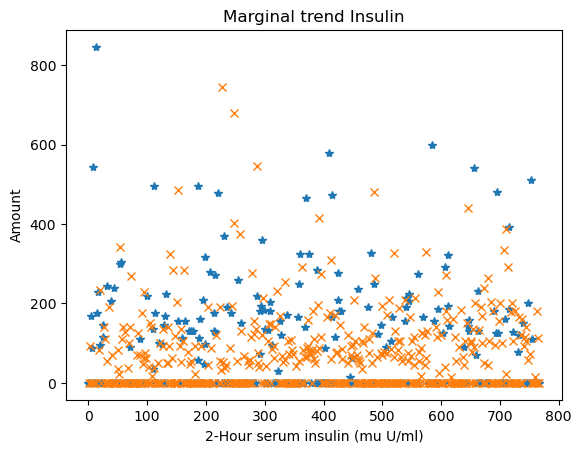

In [22]:
# Marginal influence of blood pressure
# Draw marginal trend
import matplotlib.pyplot as plt
import numpy as np
plt.plot(diab_1_data["2-Hour serum insulin (mu U/ml)"], "*")
plt.plot(diab_0_data["2-Hour serum insulin (mu U/ml)"], "x")
plt.xlabel("2-Hour serum insulin (mu U/ml)")
plt.ylabel("Amount")
plt.title("Marginal trend Insulin")
plt.show()

In [23]:
# Assuming 'df' is your DataFrame
correlation_matrix = data.data.corr()
print(correlation_matrix["Class variable"].sort_values(ascending=False))

Class variable                                                              1.000000
Plasma glucose concentration a 2 hours in an oral glucose tolerance test    0.466581
Body mass index (weight in kg/(height in m)^2)                              0.292695
Age (years)                                                                 0.238356
Number of times pregnant                                                    0.221898
Diabetes pedigree function                                                  0.173844
2-Hour serum insulin (mu U/ml)                                              0.130548
Triceps skin fold thickness (mm)                                            0.074752
Diastolic blood pressure (mm Hg)                                            0.065068
Name: Class variable, dtype: float64


In [24]:
data.data["Plasma glucose concentration a 2 hours in an oral glucose tolerance test"].unique()

array([148,  85, 183,  89, 137, 116,  78, 115, 197, 125, 110, 168, 139,
       189, 166, 100, 118, 107, 103, 126,  99, 196, 119, 143, 147,  97,
       145, 117, 109, 158,  88,  92, 122, 138, 102,  90, 111, 180, 133,
       106, 171, 159, 146,  71, 105, 101, 176, 150,  73, 187,  84,  44,
       141, 114,  95, 129,  79,   0,  62, 131, 112, 113,  74,  83, 136,
        80, 123,  81, 134, 142, 144,  93, 163, 151,  96, 155,  76, 160,
       124, 162, 132, 120, 173, 170, 128, 108, 154,  57, 156, 153, 188,
       152, 104,  87,  75, 179, 130, 194, 181, 135, 184, 140, 177, 164,
        91, 165,  86, 193, 191, 161, 167,  77, 182, 157, 178,  61,  98,
       127,  82,  72, 172,  94, 175, 195,  68, 186, 198, 121,  67, 174,
       199,  56, 169, 149,  65, 190])

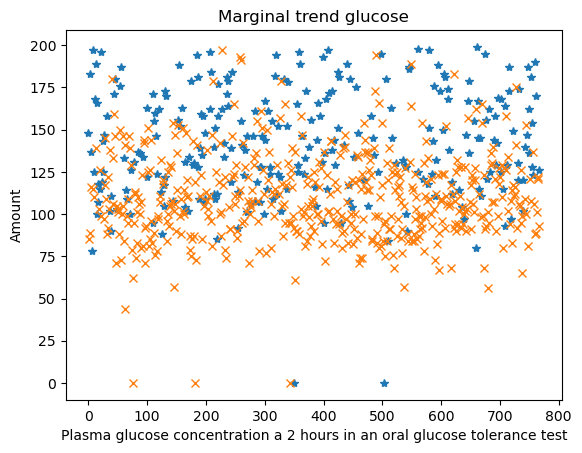

In [25]:
# Marginal influence of blood pressure
# Draw marginal trend
import matplotlib.pyplot as plt
import numpy as np
plt.plot(diab_1_data["Plasma glucose concentration a 2 hours in an oral glucose tolerance test"], "*")
plt.plot(diab_0_data["Plasma glucose concentration a 2 hours in an oral glucose tolerance test"], "x")
plt.xlabel("Plasma glucose concentration a 2 hours in an oral glucose tolerance test")
plt.ylabel("Amount")
plt.title("Marginal trend glucose")
plt.show()

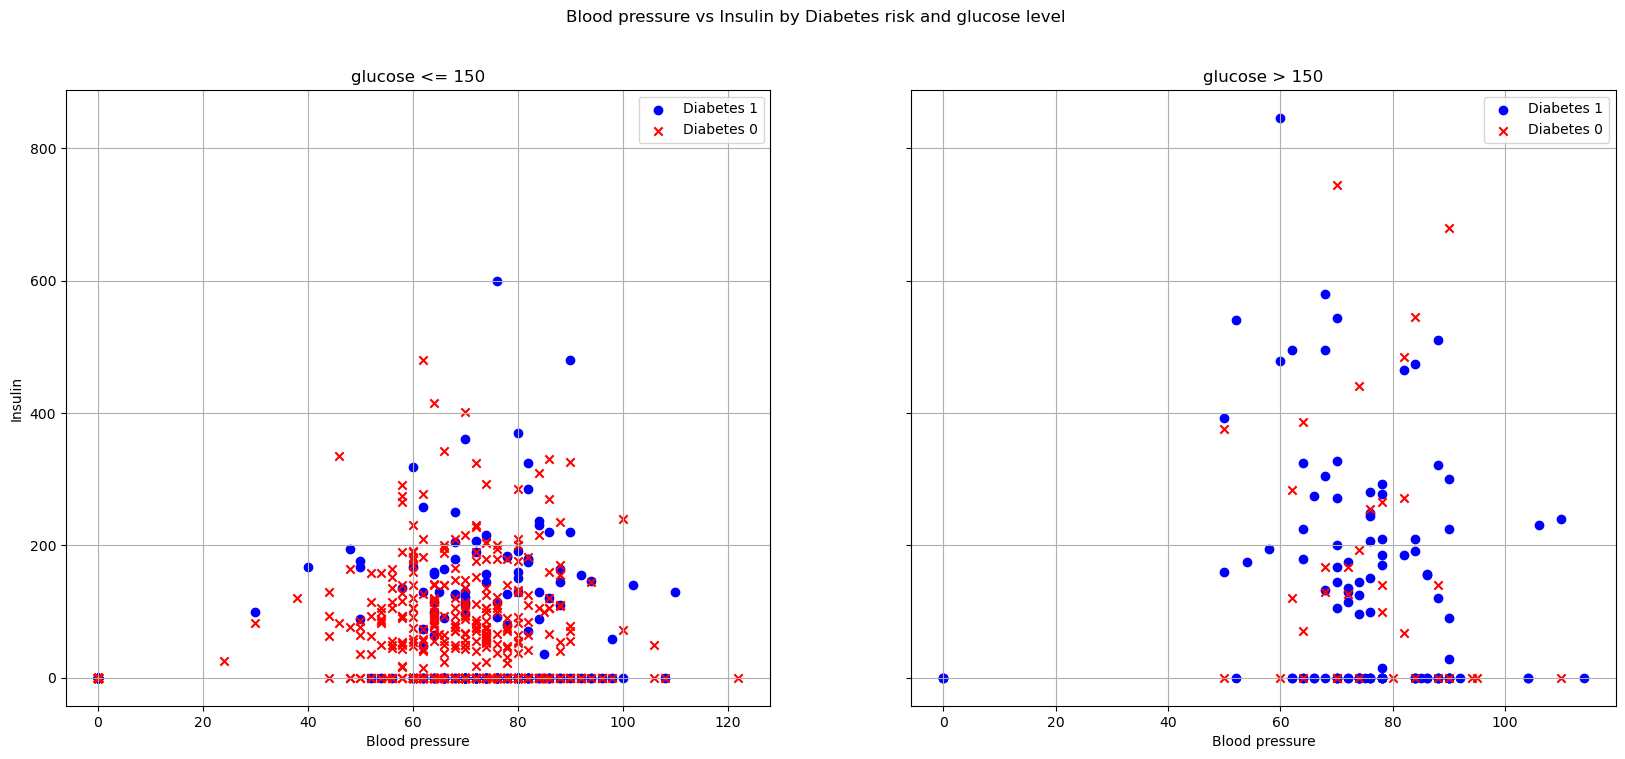

In [26]:
# Plot settings for two slices: Credit_History = 1 and Credit_History = 0
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8), sharey=True)
# Titles for the subplots
titles = ['glucose <= 150', 'glucose > 150']
# Filter data based on Credit_History and Loan_Status
for i, condition in enumerate([(data.data["Plasma glucose concentration a 2 hours in an oral glucose tolerance test"] <= 150), (data.data["Plasma glucose concentration a 2 hours in an oral glucose tolerance test"] > 150)]):
    subset = data.data[condition]
    axes[i].scatter(subset.loc[subset["Class variable"]==1, "Diastolic blood pressure (mm Hg)"], subset.loc[subset["Class variable"]==1, "2-Hour serum insulin (mu U/ml)"], color='blue', marker='o', label='Diabetes 1')
    axes[i].scatter(subset.loc[subset["Class variable"]==0, "Diastolic blood pressure (mm Hg)"], subset.loc[subset["Class variable"]==0, "2-Hour serum insulin (mu U/ml)"], color='red', marker='x', label='Diabetes 0')
    axes[i].set_title(titles[i])
    axes[i].set_xlabel('Blood pressure')
    if i == 0:
        axes[i].set_ylabel('Insulin')
    axes[i].legend()
    axes[i].grid(True)

plt.suptitle('Blood pressure vs Insulin by Diabetes risk and glucose level')
plt.show()

In [27]:
def process_stored_results(test_name= "spiral_selft4"):

    import json
    candidate_path = "results/candidates_values_"+test_name+".json"

    # Reading the JSON data from the file
    with open(candidate_path, 'r') as file:
        candidate_history = json.load(file)

    cf_point_last = candidate_history[-1]
    candidate_array = np.array(candidate_history)

    fitness_path = "results/fitness_history_"+test_name+".json"
    with open(fitness_path, 'r') as file:
        fitness_history = json.load(file)
    fitness_array = np.array(fitness_history)

    loss_path = "results/loss_history_"+test_name+".json"
    with open(loss_path, 'r') as file:
        loss_history = json.load(file)

    loss_array = np.array(loss_history)

    distance_file_path = "results/distance_history_"+test_name+".json"

    # Reading the JSON data from the file
    with open(distance_file_path, 'r') as file:
        distance_array = json.load(file)

    distance_array = np.array(distance_array)
    return cf_point_last, candidate_array, fitness_array, loss_array, distance_array

In [28]:
cf_point_last, candidate_history, fitness_array, loss_array, distance_array = process_stored_results("diab_2")

In [29]:
cf_point_last_euc, candidate_history_euc, fitness_array_euc, loss_array_euc, distance_array_euc = process_stored_results("diab_3euc")

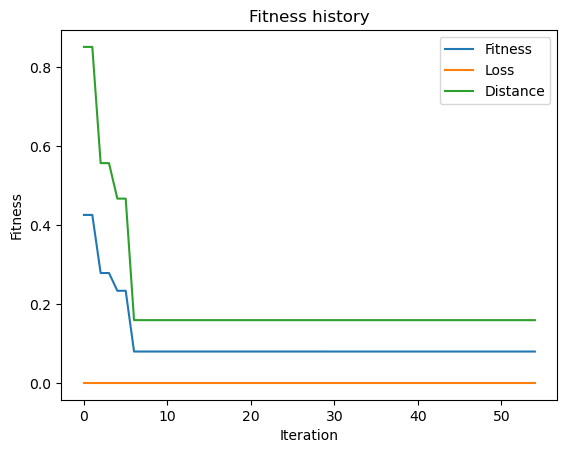

In [30]:
# Draw fitness history graph
import matplotlib.pyplot as plt
plt.plot(fitness_array)
plt.plot(loss_array)
plt.plot(distance_array)
plt.legend(["Fitness", "Loss", "Distance"])
plt.xlabel("Iteration")
plt.ylabel("Fitness")
plt.title("Fitness history")
plt.show()

In [31]:
candidate_history

array([[1.00000000e-05, 1.35212406e+02, 5.43025842e+01, 1.09360792e+01,
        2.00920488e+02, 3.49804911e+00, 9.53287800e-02, 4.14320788e+01],
       [3.00000000e-05, 1.35212426e+02, 5.43026042e+01, 1.09360992e+01,
        2.00920508e+02, 3.49806911e+00, 9.53487800e-02, 4.14888541e+01],
       [6.00000000e-05, 1.58094070e+02, 2.41036992e+00, 2.83744198e+01,
        1.84598747e+02, 1.26995693e+01, 9.56979626e-01, 4.04194352e+01],
       [6.00000000e-05, 1.58094070e+02, 2.41036992e+00, 2.83744198e+01,
        1.84598747e+02, 1.26995693e+01, 9.56979626e-01, 4.04194352e+01],
       [9.00000000e-05, 1.58094100e+02, 2.41039992e+00, 9.01916312e+01,
        1.84598777e+02, 1.26995993e+01, 9.57009626e-01, 4.04194652e+01],
       [9.00000000e-05, 1.58094100e+02, 2.41039992e+00, 9.01916312e+01,
        1.84598777e+02, 1.26995993e+01, 9.57009626e-01, 4.04194652e+01],
       [1.70000000e-04, 1.35212566e+02, 2.41047992e+00, 5.14985049e+01,
        1.75417262e+02, 1.26996793e+01, 1.33909349e+00, 4.

In [32]:
cf_point_last

[0.0005500000000000008,
 133.39591472090873,
 2.410859915357188,
 51.505889835747354,
 174.4305840369155,
 13.384211751726605,
 1.1126182152577635,
 39.28721272293484]

In [33]:
target_instance.get_list_of_features_values()

[0, 137, 40, 35, 168, 43.1, 2.2880000000000003, 33]

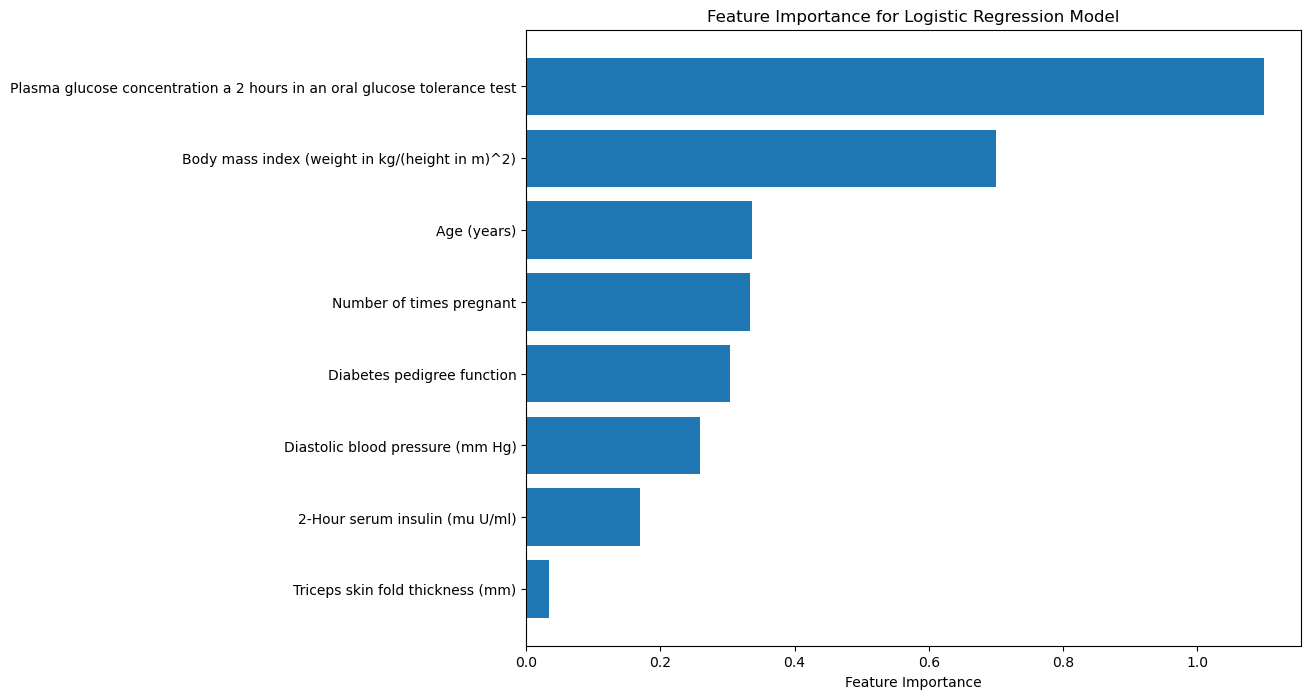

In [34]:
# Access the logistic regression model within the pipeline
log_reg_model = model_pipeline.named_steps['model']
# Assuming 'log_reg_optimized' is your trained Logistic Regression model
feature_importance = np.abs(log_reg_model.coef_[0])
features = X.columns

# Sorting the features by importance
sorted_idx = np.argsort(feature_importance)
sorted_features = features[sorted_idx]
sorted_importance = feature_importance[sorted_idx]

# Plotting
plt.figure(figsize=(10, 8))
plt.barh(sorted_features, sorted_importance)
plt.xlabel('Feature Importance')
plt.title('Feature Importance for Logistic Regression Model')
plt.show()

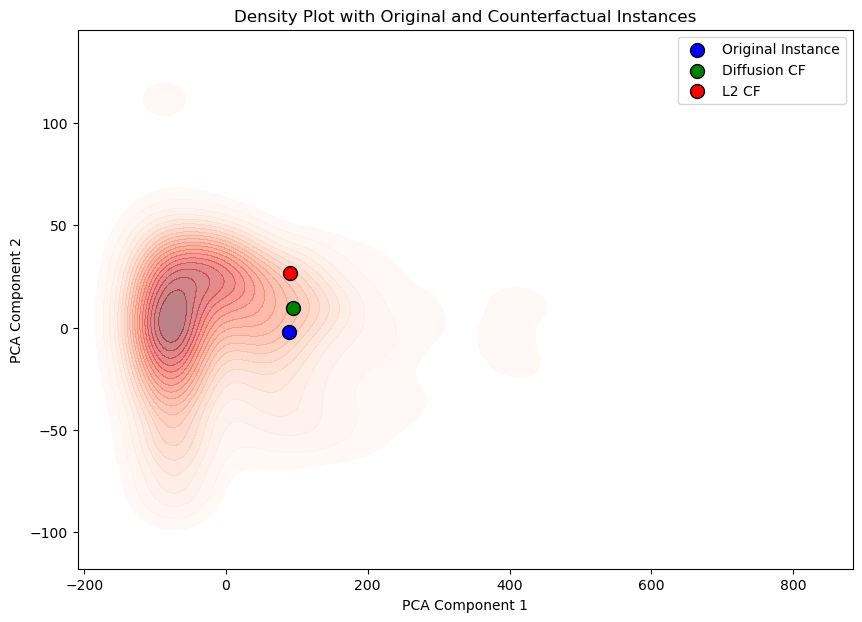

In [35]:
from sklearn.decomposition import PCA
import numpy as np
import seaborn as sns

# Simulating an example for demonstration purposes
# Let's assume X_train_scaled is your training data, and we have an original instance and two counterfactuals
original_instance = target_instance.get_list_of_features_values()
cf_diffusion = cf_point_last
cf_l2 = cf_point_last_euc

# Applying PCA to reduce dimensionality for visualization
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
instance_pca = pca.transform(np.array(original_instance).reshape(1, -1))
cf_diffusion_pca = pca.transform(np.array(cf_diffusion).reshape(1, -1))
cf_l2_pca = pca.transform(np.array(cf_l2).reshape(1, -1))

# Plotting
plt.figure(figsize=(10, 7))

# Plotting the density of the X_train distribution
sns.kdeplot(x=X_train_pca[:, 0], y=X_train_pca[:, 1], levels=20, cmap="Reds", fill=True, alpha=0.5)

# Overlaying the original instance and counterfactuals
plt.scatter(instance_pca[:, 0], instance_pca[:, 1], color='blue', label='Original Instance', s=100, edgecolor='k')
plt.scatter(cf_diffusion_pca[:, 0], cf_diffusion_pca[:, 1], color='green', label='Diffusion CF', s=100, edgecolor='k')
plt.scatter(cf_l2_pca[:, 0], cf_l2_pca[:, 1], color='red', label='L2 CF', s=100, edgecolor='k')

plt.title('Density Plot with Original and Counterfactual Instances')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

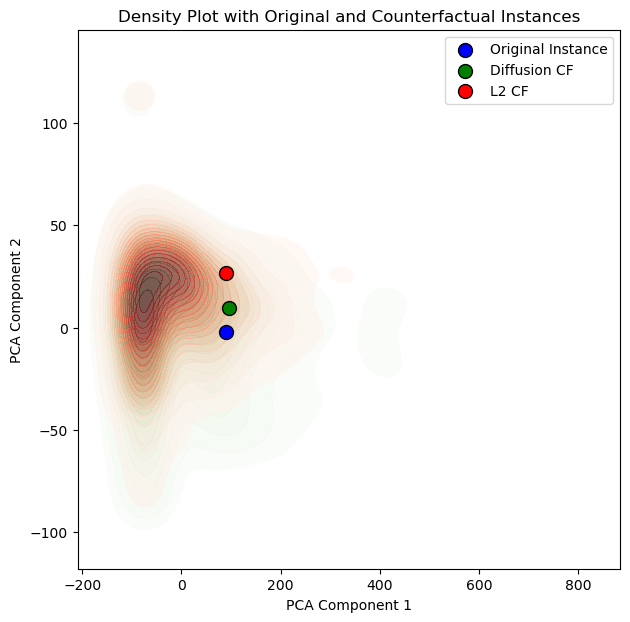

In [36]:
# Make the same plot but for subset of data where class variable is 1
from sklearn.decomposition import PCA
import numpy as np
import seaborn as sns

X_train_class0 = X_train[y_train==0]

# Simulating an example for demonstration purposes
# Let's assume X_train_scaled is your training data, and we have an original instance and two counterfactuals
original_instance = target_instance.get_list_of_features_values()
cf_diffusion = cf_point_last
cf_l2 = cf_point_last_euc

# Applying PCA to reduce dimensionality for visualization
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_train_class0_pca = pca.transform(X_train_class0)
instance_pca = pca.transform(np.array(original_instance).reshape(1, -1))
cf_diffusion_pca = pca.transform(np.array(cf_diffusion).reshape(1, -1))
cf_l2_pca = pca.transform(np.array(cf_l2).reshape(1, -1))

# Plotting
plt.figure(figsize=(7, 7))

# Plotting the density of the X_train distribution
sns.kdeplot(x=X_train_pca[:, 0], y=X_train_pca[:, 1], levels=20, cmap="Greens", fill=True, alpha=0.5)
# Plotting the density of the class 0 distribution
sns.kdeplot(x=X_train_class0_pca[:, 0], y=X_train_class0_pca[:, 1], levels=20, cmap="Reds", fill=True, alpha=0.5)

# Overlaying the original instance and counterfactuals
plt.scatter(instance_pca[:, 0], instance_pca[:, 1], color='blue', label='Original Instance', s=100, edgecolor='k')
plt.scatter(cf_diffusion_pca[:, 0], cf_diffusion_pca[:, 1], color='green', label='Diffusion CF', s=100, edgecolor='k')
plt.scatter(cf_l2_pca[:, 0], cf_l2_pca[:, 1], color='red', label='L2 CF', s=100, edgecolor='k')

plt.title('Density Plot with Original and Counterfactual Instances')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

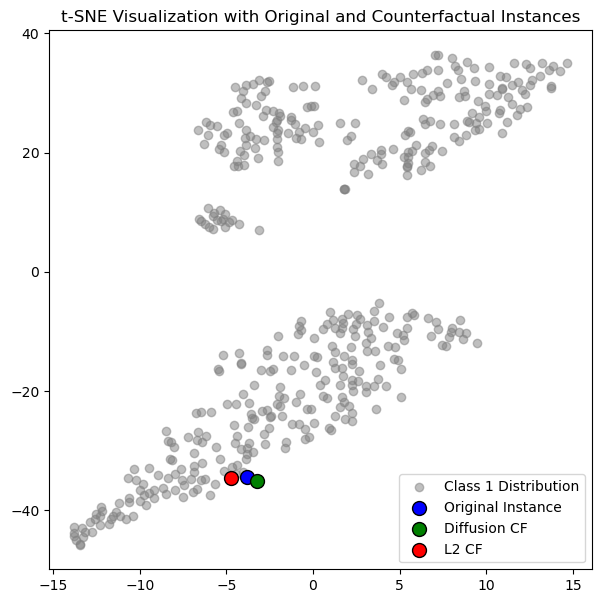

In [37]:
# Make the same plot but for subset of data where class variable is 1
# Some plot but t-sne
from sklearn.manifold import TSNE
import numpy as np
import seaborn as sns

X_train_class0 = X_train[y_train==0]

# Simulating an example for demonstration purposes
# Let's assume X_train_scaled is your training data, and we have an original instance and two counterfactuals
original_instance = target_instance.get_list_of_features_values()
cf_diffusion = cf_point_last
cf_l2 = cf_point_last_euc

tsne = TSNE(n_components=2, random_state=32, learning_rate='auto', init='random')

# Simulating the original instance and two counterfactuals as numpy arrays for demonstration
# Assuming 'original_instance', 'cf_diffusion', and 'cf_l2' are available as lists or numpy arrays
original_instance_np = np.array(original_instance).reshape(1, -1)
cf_diffusion_np = np.array(cf_diffusion).reshape(1, -1)
cf_l2_np = np.array(cf_l2).reshape(1, -1)

# Combine X_train_class1 with the original instance and counterfactuals for t-SNE transformation
combined_data = np.vstack((X_train_class0, original_instance_np, cf_diffusion_np, cf_l2_np))

# Apply t-SNE to the combined dataset
combined_tsne = tsne.fit_transform(combined_data)

# Extracting the transformed coordinates for plotting
X_train_tsne = combined_tsne[:-3]  # Exclude the last three points which are the original and counterfactuals
instance_tsne = combined_tsne[-3]
cf_diffusion_tsne = combined_tsne[-2]
cf_l2_tsne = combined_tsne[-1]

# Plotting
plt.figure(figsize=(7, 7))

# Since t-SNE does not directly support density estimation, scatter plot the X_train_class1 distribution
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], color='gray', alpha=0.5, label='Class 1 Distribution')

# Overlaying the original instance and counterfactuals
plt.scatter(instance_tsne[0], instance_tsne[1], color='blue', label='Original Instance', s=100, edgecolor='k')
plt.scatter(cf_diffusion_tsne[0], cf_diffusion_tsne[1], color='green', label='Diffusion CF', s=100, edgecolor='k')
plt.scatter(cf_l2_tsne[0], cf_l2_tsne[1], color='red', label='L2 CF', s=100, edgecolor='k')

plt.title('t-SNE Visualization with Original and Counterfactual Instances')
plt.legend()
plt.show()

In [38]:
original_instance_np

array([[  0.   , 137.   ,  40.   ,  35.   , 168.   ,  43.1  ,   2.288,
         33.   ]])

In [39]:
cf_diffusion_np

array([[5.50000000e-04, 1.33395915e+02, 2.41085992e+00, 5.15058898e+01,
        1.74430584e+02, 1.33842118e+01, 1.11261822e+00, 3.92872127e+01]])

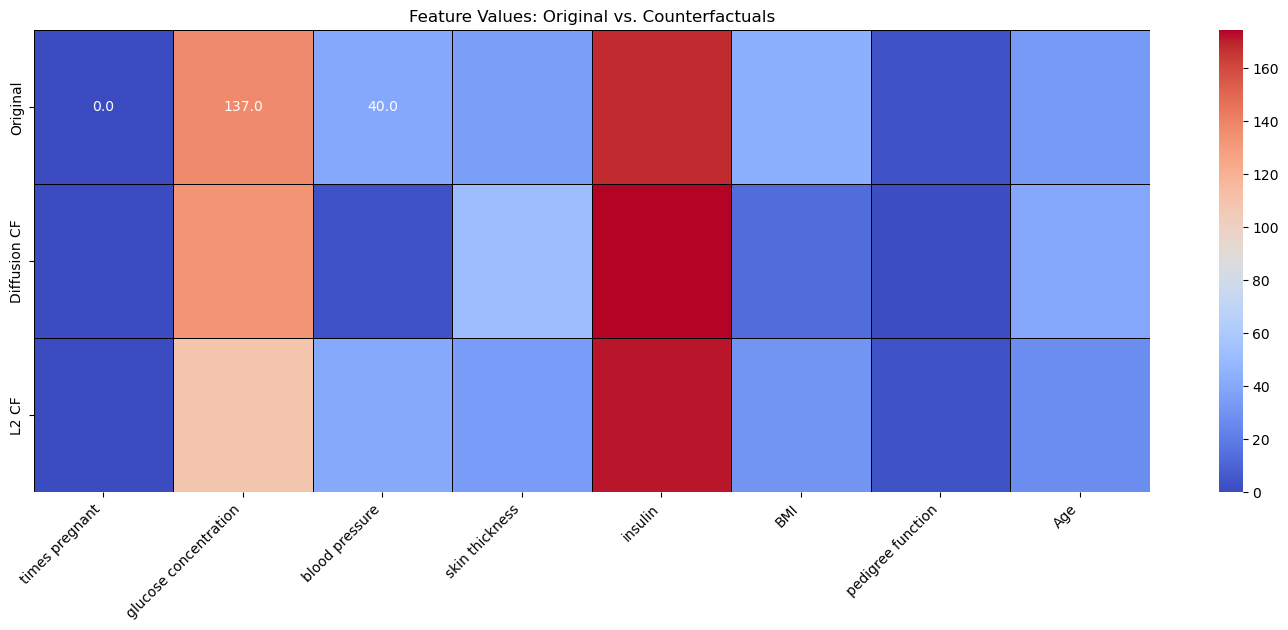

In [43]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

instances_df_rounded = original_instance_np.round(1)
cf_diffusion_df_rounded = cf_diffusion_np.round(1)
cf_l2_df_rounded = cf_l2_np.round(1)
# Assuming your numpy arrays are named original_instance_np, cf_diffusion_np, and cf_l2_np
instances_matrix = np.vstack([instances_df_rounded, cf_diffusion_df_rounded, cf_l2_df_rounded])

# Optionally, create a DataFrame for better visualization
features = ['times pregnant','glucose concentration','blood pressure','skin thickness','insulin','BMI','pedigree function','Age']  
instances_df = pd.DataFrame(instances_matrix, index=['Original', 'Diffusion CF', 'L2 CF'], columns=features)

# Generate the heatmap
plt.figure(figsize=(18, 6))  # Adjust the figure size as needed
sns.heatmap(instances_df,annot=True, cmap='coolwarm', cbar=True, linewidths=0.5, linecolor='black', fmt=".1f")
plt.xticks(rotation=45, ha="right")  # Rotate column labels for better fit
plt.title('Feature Values: Original vs. Counterfactuals')
plt.show()

In [49]:
import plotly.graph_objects as go

# Assuming your numpy arrays are named original_instance_np, cf_diffusion_np, and cf_l2_np
instances_matrix = np.vstack([cf_diffusion_df_rounded, instances_df_rounded, cf_l2_df_rounded])

# Assuming instances_matrix and features are defined as per your provided data
fig = go.Figure(data=go.Heatmap(
    z=instances_matrix,  # Heatmap values
    x=features,  # Feature names for columns
    y=['Diffusion CF', 'Original', 'L2 CF'],  # Row labels
    colorscale='twilight',  # Color scale
    text=instances_matrix.round(2),  # Rounded values for annotations
    texttemplate="%{text}",  # Template to display text
    hoverongaps=False))  # No gaps in data

fig.update_layout(
    title='Feature Values: Original vs. Counterfactuals',
    xaxis=dict(title='Features'),
    yaxis=dict(title='Instances')
)

fig.show()

In [42]:
import seaborn as sns

# Assuming 'original_instances_df' and 'counterfactuals_df' are your data frames
# Concatenate original instances and counterfactuals for comparison
combined_df = pd.concat([original_instances_df, counterfactuals_df])

# Use seaborn to create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(combined_df, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap of Original Instances and Counterfactuals')
plt.show()

NameError: name 'original_instances_df' is not defined

In [50]:
# Make a loop of finding 10 counterfactuals for 10 different instances


,Number of times pregnant,Plasma glucose concentration a 2 hours in an oral glucose tolerance test,Diastolic blood pressure (mm Hg),Triceps skin fold thickness (mm),2-Hour serum insulin (mu U/ml),Body mass index (weight in kg/(height in m)^2),Diabetes pedigree function,Age (years)
668,6,98,58,33,190,34.0,0.430,43
324,2,112,75,32,0,35.7,0.148,21
624,2,108,64,0,0,30.8,0.158,21
690,8,107,80,0,0,24.6,0.856,34
473,7,136,90,0,0,29.9,0.210,50
